In [216]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, GRU
from keras.layers import Conv2D, MaxPooling2D
from keras import losses, metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing

## Part 1

In [2]:
All_features = pd.read_csv("Full_featuresUpdated.csv")
All_features['Date'] = pd.to_datetime(All_features['Date'])
All_features.set_index("Date", inplace=True)
All_features.head()


,BTCPrice(USD),BTCTransVolume,BTCPriceVol,BTCMinerRev(USD),BTCTranFee(BTC),BlockSize,HashRate,InflationRate,EtherPrice(USD),BCHPrice(USD),XRPPrice(USD),LTCPrice(USD)
Date,,,,,,,,,,,,
2010-01-01,0.0,138,0.0,0.0,0.0,216,0.000008,NaN,NaN,0.0,NaN,NaN
2010-01-02,0.0,134,0.0,0.0,0.0,218,0.000008,NaN,NaN,0.0,NaN,NaN
2010-01-03,0.0,126,0.0,0.0,0.0,216,0.000007,NaN,NaN,0.0,NaN,NaN
2010-01-04,0.0,186,0.0,0.0,0.0,216,0.000007,NaN,NaN,0.0,NaN,NaN
2010-01-05,0.0,183,0.0,0.0,0.0,269,0.000008,NaN,NaN,0.0,NaN,NaN


In [3]:
print(pd.isnull(All_features).sum())

BTCPrice(USD)          0
BTCTransVolume         0
BTCPriceVol            0
BTCMinerRev(USD)       0
BTCTranFee(BTC)        0
BlockSize              0
HashRate               0
InflationRate        401
EtherPrice(USD)     2036
BCHPrice(USD)          0
XRPPrice(USD)       1846
LTCPrice(USD)       1392
dtype: int64


Text(0, 0.5, 'USD')

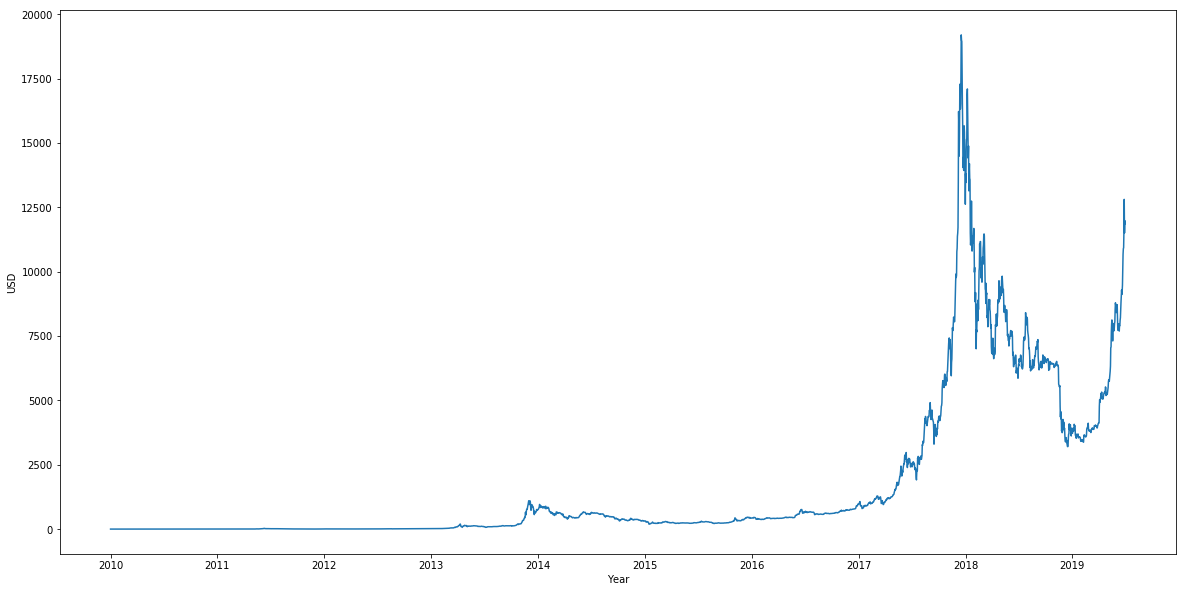

In [4]:
plt.figure(figsize=(20,10))
plt.plot(All_features['BTCPrice(USD)'])
plt.xlabel('Year')
plt.ylabel('USD')

In [95]:
scale_feature = pd.DataFrame(preprocessing.scale(All_features), columns=All_features.columns, index=All_features.index)
scale_feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3468 entries, 2010-01-01 to 2019-06-30
Data columns (total 12 columns):
BTCPrice(USD)       3468 non-null float64
BTCTransVolume      3468 non-null float64
BTCPriceVol         3468 non-null float64
BTCMinerRev(USD)    3468 non-null float64
BTCTranFee(BTC)     3468 non-null float64
BlockSize           3468 non-null float64
HashRate            3468 non-null float64
InflationRate       3067 non-null float64
EtherPrice(USD)     1432 non-null float64
BCHPrice(USD)       3468 non-null float64
XRPPrice(USD)       1622 non-null float64
LTCPrice(USD)       2076 non-null float64
dtypes: float64(12)
memory usage: 352.2 KB


C:\Users\Xiyu Liu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Scale value')

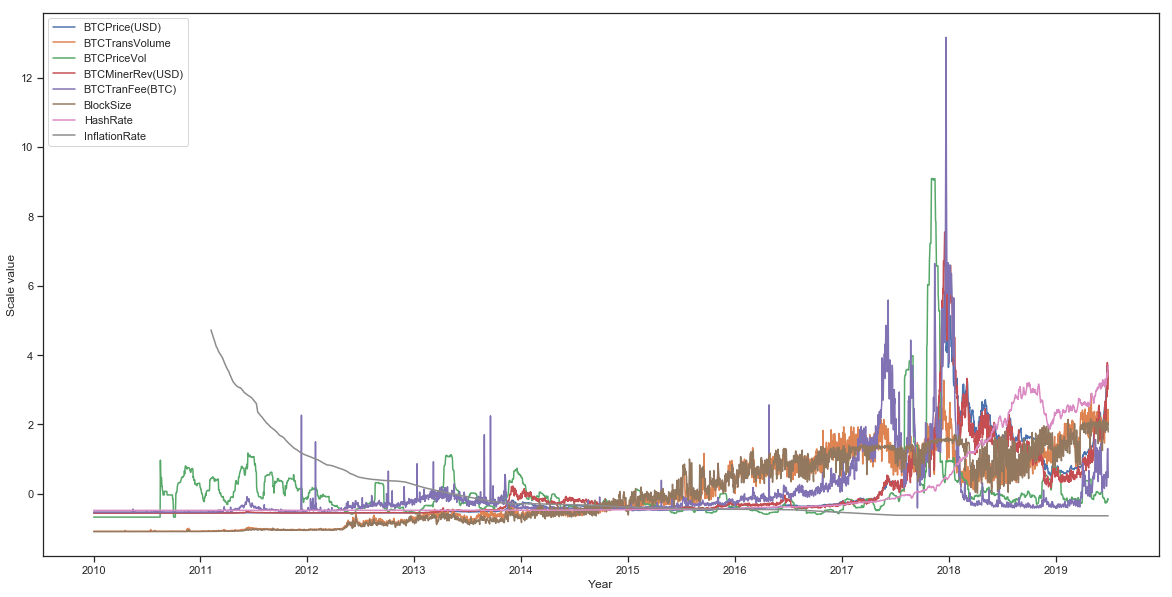

In [94]:
plt.figure(figsize=(20,10))
plt.plot(scale_feature.iloc[:,0],label='BTCPrice(USD)')
plt.plot(scale_feature.iloc[:,1],label='BTCTransVolume')
plt.plot(scale_feature.iloc[:,2],label='BTCPriceVol')
plt.plot(scale_feature.iloc[:,3],label='BTCMinerRev(USD)')
plt.plot(scale_feature.iloc[:,4],label='BTCTranFee(BTC)')
plt.plot(scale_feature.iloc[:,5],label='BlockSize')
plt.plot(scale_feature.iloc[:,6],label='HashRate')
plt.plot(scale_feature.iloc[:,7],label='InflationRate')
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Scale value')

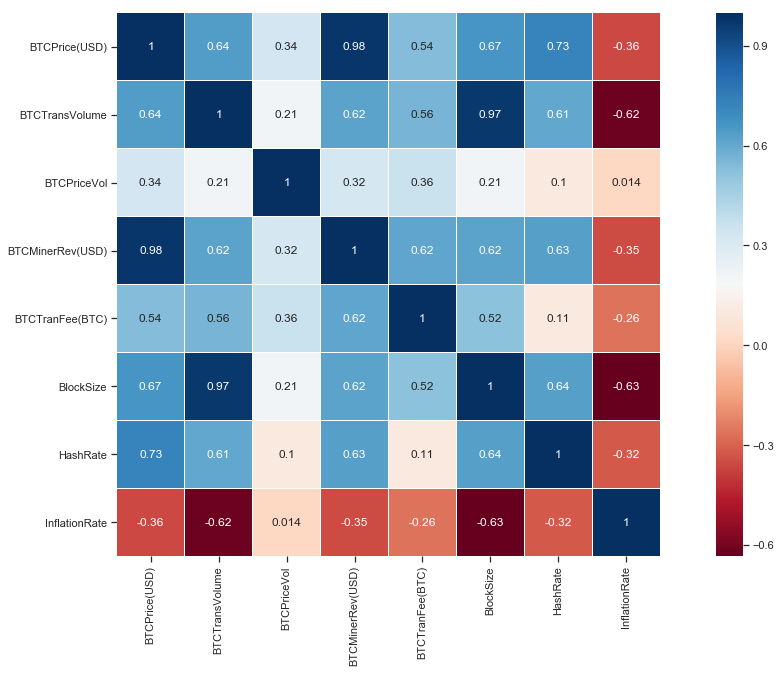

In [96]:
df_corr = scale_feature.iloc[:,:8].copy()

colormap = plt.cm.RdBu
plt.figure(figsize=(20,10))
sns.heatmap(df_corr.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

C:\Users\Xiyu Liu\Anaconda3\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Xiyu Liu\Anaconda3\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


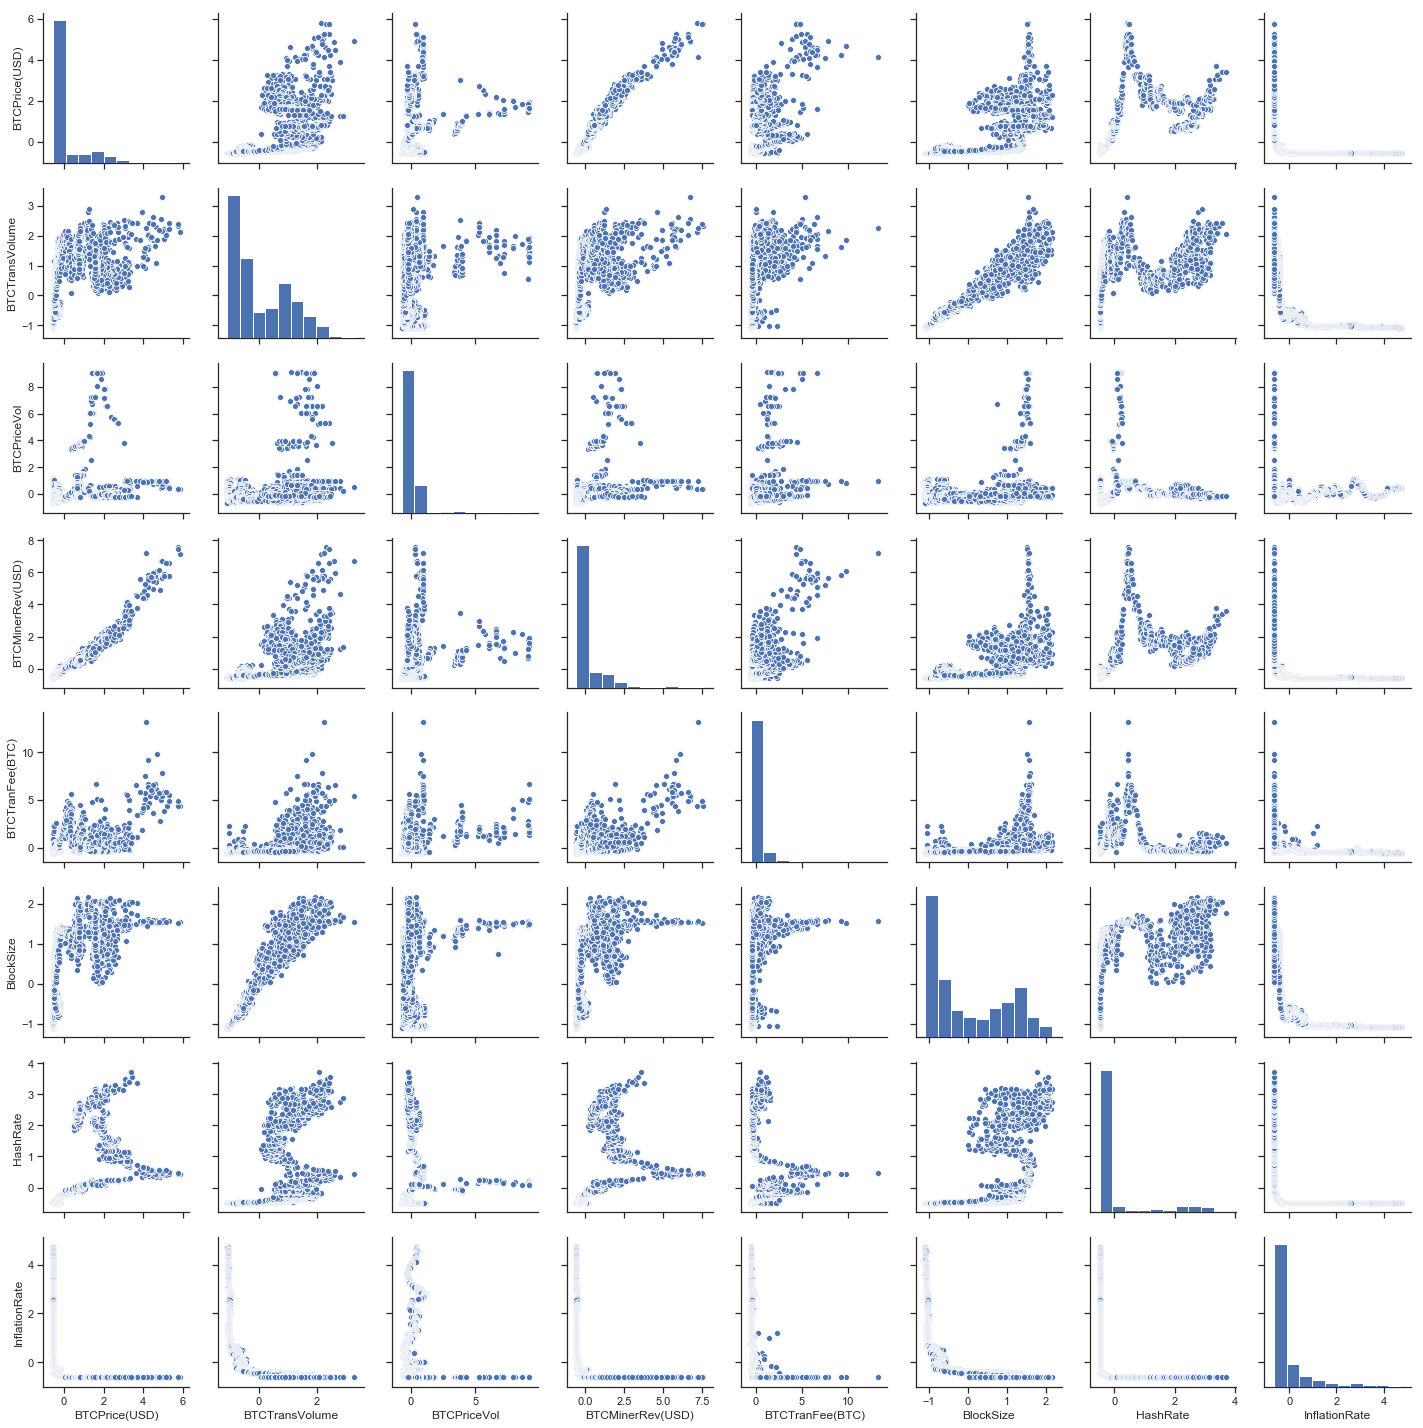

In [97]:
d_f = scale_feature.iloc[:,:8].copy()
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(d_f)

According to the plot above, we can conclude that the BTC price is not stationary and have a strong correlation with the BTC Miner Revenue. Also, the BTC Miner Revenue has a stronger correlationship with the Transaction fee.

## Part 2

Since each prediction date need a window of 34 days(28 lookback days and 7 forward target days), the perdiction date range will be Jan 28, 2010 to Jun 23, 2019. Then the three sets become:

Train: Jan 28, 2010 - June 30, 2018 (total 3076 observations)

Validation: July 1, 2018 - Dec 31, 2018 (total 184 observations)

Test: Jan 1, 2019 - Jun 23, 2019 (total 174 observations)

In [98]:
feature_data = scale_feature.iloc[:,:7].copy()
LB_df = feature_data.loc[feature_data.index<='2019-06-23'].copy()
Tgt_df = feature_data.loc[feature_data.index>='2010-01-29'].copy()
LB_win=28
Tgt_win=7
Train_size=3076
Valid_size=184
Test_size=174

In [99]:
def Lookback(win,df):
    as_strided = np.lib.stride_tricks.as_strided
    v = as_strided(df, (len(df) - (win - 1), win, df.shape[1]), (df.values.strides[0],df.values.strides[0],df.values.strides[1]))
    return v

def Target(win,df):
    as_strided = np.lib.stride_tricks.as_strided
    v = as_strided(df, (len(df) - (win - 1), win), (df.values.strides * 2))
    return v

In [100]:
LB_data = Lookback(LB_win,LB_df)
np.shape(LB_data)

(3434, 28, 7)

In [101]:
Tgt_data = Target(Tgt_win,Tgt_df.iloc[:,0])
np.shape(Tgt_data)

(3434, 7)

In [102]:
Train_LB = LB_data[:Train_size,:,:]
Valid_LB = LB_data[Train_size:Train_size+Valid_size,:,:]
Test_LB = LB_data[-Test_size:,:,:]
print(np.shape(Train_LB))
print(np.shape(Valid_LB))
print(np.shape(Test_LB))

(3076, 28, 7)
(184, 28, 7)
(174, 28, 7)


In [103]:
Train_Tgt = Tgt_data[:Train_size,:]
Valid_Tgt = Tgt_data[Train_size:Train_size+Valid_size,:]
Test_Tgt = Tgt_data[-Test_size:,:]
print(np.shape(Train_Tgt))
print(np.shape(Valid_Tgt))
print(np.shape(Test_Tgt))

(3076, 7)
(184, 7)
(174, 7)


## Part 3

### 3.1
Building 2 benchmarks

In [104]:
Avg_Bmk = feature_data.iloc[:,0].copy()
Avg_Bmk = Avg_Bmk.loc[(Avg_Bmk.index>='2018-06-04')&(Avg_Bmk.index<='2018-12-31')].rolling('28D').mean()
Avg_Bmk_valid = Avg_Bmk[27:]
Valid_Avg = np.tile(Avg_Bmk_valid.as_matrix(),(7,1)).T
Valid_Avg_Bmk = mean_absolute_error(Valid_Avg,Valid_Tgt)
Valid_Avg_Bmk

C:\Users\Xiyu Liu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


0.18461257602255127

In [105]:
Last_Bmk = feature_data.iloc[:,0].copy()
Last_Bmk_valid = Last_Bmk.loc[(Last_Bmk.index>='2018-07-01')&(Last_Bmk.index<='2018-12-31')]
Valid_Last = np.tile(Last_Bmk_valid.as_matrix(),(7,1)).T
Valid_Last_Bmk = mean_absolute_error(Valid_Last,Valid_Tgt)
Valid_Last_Bmk

C:\Users\Xiyu Liu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


0.09632072688679146

### 3.2

In [151]:
train_x = Train_LB
train_y = Train_Tgt

val_x = Valid_LB
val_y = Valid_Tgt

In [148]:
def simple_NN():
    model = Sequential()
    model.add(Flatten(input_shape = (LB_win, feature_data.shape[1])))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='linear'))
    model.compile(optimizer='sgd',loss='mae',metrics=['accuracy','mae'])
    return model

In [150]:
model_simple = simple_NN()
model_simple.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 196)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                6304      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 231       
Total params: 6,535
Trainable params: 6,535
Non-trainable params: 0
_________________________________________________________________


In [152]:
model_simple_fit = model_simple.fit(train_x, train_y, epochs=200, batch_size=66,
          validation_data=(val_x, val_y))



Train on 3076 samples, validate on 184 samples
Epoch 1/200
3076/3076 [==============================] - 1s 474us/step - loss: 0.5923 - acc: 0.1118 - mean_absolute_error: 0.5923 - val_loss: 0.7362 - val_acc: 0.0815 - val_mean_absolute_error: 0.7362
Epoch 2/200
3076/3076 [==============================] - 0s 38us/step - loss: 0.2843 - acc: 0.1024 - mean_absolute_error: 0.2843 - val_loss: 0.5756 - val_acc: 0.1141 - val_mean_absolute_error: 0.5756
Epoch 3/200
3076/3076 [==============================] - 0s 27us/step - loss: 0.1669 - acc: 0.1258 - mean_absolute_error: 0.1669 - val_loss: 0.5511 - val_acc: 0.1087 - val_mean_absolute_error: 0.5511
Epoch 4/200
3076/3076 [==============================] - 0s 31us/step - loss: 0.1412 - acc: 0.1388 - mean_absolute_error: 0.1412 - val_loss: 0.5883 - val_acc: 0.1087 - val_mean_absolute_error: 0.5883
Epoch 5/200
3076/3076 [==============================] - 0s 40us/step - loss: 0.1329 - acc: 0.1437 - mean_absolute_error: 0.1329 - val_loss: 0.5491 - 

Epoch 40/200
3076/3076 [==============================] - 0s 36us/step - loss: 0.0752 - acc: 0.1466 - mean_absolute_error: 0.0752 - val_loss: 0.4672 - val_acc: 0.1141 - val_mean_absolute_error: 0.4672
Epoch 41/200
3076/3076 [==============================] - 0s 39us/step - loss: 0.0743 - acc: 0.1421 - mean_absolute_error: 0.0743 - val_loss: 0.4481 - val_acc: 0.1141 - val_mean_absolute_error: 0.4481
Epoch 42/200
3076/3076 [==============================] - 0s 40us/step - loss: 0.0738 - acc: 0.1460 - mean_absolute_error: 0.0738 - val_loss: 0.4286 - val_acc: 0.1304 - val_mean_absolute_error: 0.4286
Epoch 43/200
3076/3076 [==============================] - 0s 41us/step - loss: 0.0734 - acc: 0.1424 - mean_absolute_error: 0.0734 - val_loss: 0.4362 - val_acc: 0.1141 - val_mean_absolute_error: 0.4362
Epoch 44/200
3076/3076 [==============================] - 0s 39us/step - loss: 0.0726 - acc: 0.1466 - mean_absolute_error: 0.0726 - val_loss: 0.4566 - val_acc: 0.1033 - val_mean_absolute_error: 0.

Epoch 81/200
3076/3076 [==============================] - 0s 42us/step - loss: 0.0579 - acc: 0.1424 - mean_absolute_error: 0.0579 - val_loss: 0.3154 - val_acc: 0.1793 - val_mean_absolute_error: 0.3154
Epoch 82/200
3076/3076 [==============================] - 0s 38us/step - loss: 0.0575 - acc: 0.1443 - mean_absolute_error: 0.0575 - val_loss: 0.3166 - val_acc: 0.1739 - val_mean_absolute_error: 0.3166
Epoch 83/200
3076/3076 [==============================] - 0s 41us/step - loss: 0.0571 - acc: 0.1427 - mean_absolute_error: 0.0571 - val_loss: 0.3078 - val_acc: 0.1902 - val_mean_absolute_error: 0.3078
Epoch 84/200
3076/3076 [==============================] - 0s 39us/step - loss: 0.0568 - acc: 0.1434 - mean_absolute_error: 0.0568 - val_loss: 0.3132 - val_acc: 0.1957 - val_mean_absolute_error: 0.3132
Epoch 85/200
3076/3076 [==============================] - 0s 39us/step - loss: 0.0566 - acc: 0.1486 - mean_absolute_error: 0.0566 - val_loss: 0.3140 - val_acc: 0.2011 - val_mean_absolute_error: 0.

Epoch 122/200
3076/3076 [==============================] - 0s 43us/step - loss: 0.0481 - acc: 0.1492 - mean_absolute_error: 0.0481 - val_loss: 0.2765 - val_acc: 0.2065 - val_mean_absolute_error: 0.2765
Epoch 123/200
3076/3076 [==============================] - 0s 42us/step - loss: 0.0479 - acc: 0.1521 - mean_absolute_error: 0.0479 - val_loss: 0.2639 - val_acc: 0.1793 - val_mean_absolute_error: 0.2639
Epoch 124/200
3076/3076 [==============================] - 0s 40us/step - loss: 0.0480 - acc: 0.1473 - mean_absolute_error: 0.0480 - val_loss: 0.2691 - val_acc: 0.1576 - val_mean_absolute_error: 0.2691
Epoch 125/200
3076/3076 [==============================] - 0s 41us/step - loss: 0.0475 - acc: 0.1525 - mean_absolute_error: 0.0475 - val_loss: 0.2723 - val_acc: 0.2228 - val_mean_absolute_error: 0.2723
Epoch 126/200
3076/3076 [==============================] - 0s 38us/step - loss: 0.0473 - acc: 0.1482 - mean_absolute_error: 0.0473 - val_loss: 0.2636 - val_acc: 0.1957 - val_mean_absolute_erro

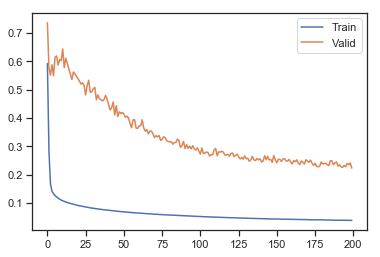

In [153]:
plt.plot(model_simple_fit.history['loss'],label='Train')
plt.plot(model_simple_fit.history['val_loss'],label='Valid')
plt.legend()
plt.show()

### 3.3

In [163]:
def model_LSTM():
    model_lstm = Sequential()
    #model_lstm.add(Flatten(input_shape = (LB_win, feature_data.shape[1])))
    model_lstm.add(LSTM(5, input_shape=(LB_win,feature_data.shape[1]), activation='linear', return_sequences=False))
    model_lstm.add(Dense(7))
    model_lstm.compile(optimizer='adam',
                 loss='mae',
                 metrics=['accuracy','mae'])
    return model_lstm
model_lstm=model_LSTM()
model_lstm.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 5)                 260       
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 42        
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


In [164]:
model_lstm_fit = model_lstm.fit(train_x, train_y, epochs=200, batch_size=66,
          validation_data=(val_x, val_y))

Train on 3076 samples, validate on 184 samples
Epoch 1/200
3076/3076 [==============================] - 3s 1ms/step - loss: 0.6234 - acc: 0.1125 - mean_absolute_error: 0.6234 - val_loss: 1.0243 - val_acc: 0.0870 - val_mean_absolute_error: 1.0243
Epoch 2/200
3076/3076 [==============================] - 1s 339us/step - loss: 0.4560 - acc: 0.1297 - mean_absolute_error: 0.4560 - val_loss: 1.0166 - val_acc: 0.1033 - val_mean_absolute_error: 1.0166
Epoch 3/200
3076/3076 [==============================] - 1s 329us/step - loss: 0.3491 - acc: 0.1382 - mean_absolute_error: 0.3491 - val_loss: 1.4842 - val_acc: 0.1141 - val_mean_absolute_error: 1.4842
Epoch 4/200
3076/3076 [==============================] - 1s 332us/step - loss: 0.2615 - acc: 0.1414 - mean_absolute_error: 0.2615 - val_loss: 2.0752 - val_acc: 0.1141 - val_mean_absolute_error: 2.0752
Epoch 5/200
3076/3076 [==============================] - 1s 326us/step - loss: 0.2108 - acc: 0.1450 - mean_absolute_error: 0.2108 - val_loss: 1.1534 - 

Epoch 82/200
3076/3076 [==============================] - 1s 373us/step - loss: 0.0321 - acc: 0.1905 - mean_absolute_error: 0.0321 - val_loss: 0.1831 - val_acc: 0.1467 - val_mean_absolute_error: 0.1831
Epoch 83/200
3076/3076 [==============================] - 1s 378us/step - loss: 0.0322 - acc: 0.1993 - mean_absolute_error: 0.0322 - val_loss: 0.1916 - val_acc: 0.1685 - val_mean_absolute_error: 0.1916
Epoch 84/200
3076/3076 [==============================] - 1s 375us/step - loss: 0.0319 - acc: 0.1902 - mean_absolute_error: 0.0319 - val_loss: 0.1748 - val_acc: 0.1630 - val_mean_absolute_error: 0.1748
Epoch 85/200
3076/3076 [==============================] - 1s 384us/step - loss: 0.0322 - acc: 0.1944 - mean_absolute_error: 0.0322 - val_loss: 0.1818 - val_acc: 0.1685 - val_mean_absolute_error: 0.1818
Epoch 86/200
3076/3076 [==============================] - 1s 373us/step - loss: 0.0320 - acc: 0.1876 - mean_absolute_error: 0.0320 - val_loss: 0.1804 - val_acc: 0.1576 - val_mean_absolute_erro

3076/3076 [==============================] - 1s 368us/step - loss: 0.0271 - acc: 0.1967 - mean_absolute_error: 0.0271 - val_loss: 0.1940 - val_acc: 0.1793 - val_mean_absolute_error: 0.1940
Epoch 163/200
3076/3076 [==============================] - 1s 359us/step - loss: 0.0285 - acc: 0.2003 - mean_absolute_error: 0.0285 - val_loss: 0.1749 - val_acc: 0.1739 - val_mean_absolute_error: 0.1749
Epoch 164/200
3076/3076 [==============================] - 1s 366us/step - loss: 0.0275 - acc: 0.1892 - mean_absolute_error: 0.0275 - val_loss: 0.1634 - val_acc: 0.1685 - val_mean_absolute_error: 0.1634
Epoch 165/200
3076/3076 [==============================] - 1s 369us/step - loss: 0.0276 - acc: 0.1970 - mean_absolute_error: 0.0276 - val_loss: 0.1854 - val_acc: 0.1957 - val_mean_absolute_error: 0.1854
Epoch 166/200
3076/3076 [==============================] - 1s 363us/step - loss: 0.0278 - acc: 0.1840 - mean_absolute_error: 0.0278 - val_loss: 0.1791 - val_acc: 0.1902 - val_mean_absolute_error: 0.1791

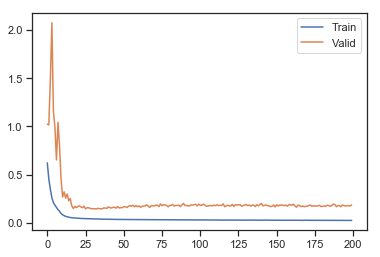

In [165]:
plt.plot(model_lstm_fit.history['loss'],label='Train')
plt.plot(model_lstm_fit.history['val_loss'],label='Valid')
plt.legend()
plt.show()

### 3.4

In [166]:
def model_GRU():
    model_gru = Sequential()
    model_gru.add(GRU(8, input_shape = (LB_win, feature_data.shape[1]), activation='linear', return_sequences=False, recurrent_dropout=0))
    model_gru.add(Dense(7))
    model_gru.compile(loss='mae', optimizer='adam',  metrics=['accuracy','mae'])
    return model_gru
model_gru=model_GRU()
model_gru.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 8)                 384       
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 63        
Total params: 447
Trainable params: 447
Non-trainable params: 0
_________________________________________________________________


In [167]:
model_gru_fit = model_gru.fit(train_x, train_y, epochs=200, batch_size=66,
          validation_data=(val_x, val_y))

Train on 3076 samples, validate on 184 samples
Epoch 1/200
3076/3076 [==============================] - 3s 1ms/step - loss: 0.7418 - acc: 0.0907 - mean_absolute_error: 0.7418 - val_loss: 1.3918 - val_acc: 0.1087 - val_mean_absolute_error: 1.3918
Epoch 2/200
3076/3076 [==============================] - 1s 266us/step - loss: 0.4874 - acc: 0.0933 - mean_absolute_error: 0.4874 - val_loss: 1.0834 - val_acc: 0.1141 - val_mean_absolute_error: 1.0834
Epoch 3/200
3076/3076 [==============================] - 1s 250us/step - loss: 0.3226 - acc: 0.0920 - mean_absolute_error: 0.3226 - val_loss: 0.6609 - val_acc: 0.0978 - val_mean_absolute_error: 0.6609
Epoch 4/200
3076/3076 [==============================] - 1s 240us/step - loss: 0.2027 - acc: 0.1096 - mean_absolute_error: 0.2027 - val_loss: 0.3834 - val_acc: 0.0978 - val_mean_absolute_error: 0.3834
Epoch 5/200
3076/3076 [==============================] - 1s 241us/step - loss: 0.1389 - acc: 0.1612 - mean_absolute_error: 0.1389 - val_loss: 0.3202 - 

Epoch 82/200
3076/3076 [==============================] - 1s 251us/step - loss: 0.0288 - acc: 0.2019 - mean_absolute_error: 0.0288 - val_loss: 0.1313 - val_acc: 0.2500 - val_mean_absolute_error: 0.1313
Epoch 83/200
3076/3076 [==============================] - 1s 258us/step - loss: 0.0295 - acc: 0.1808 - mean_absolute_error: 0.0295 - val_loss: 0.1263 - val_acc: 0.2554 - val_mean_absolute_error: 0.1263
Epoch 84/200
3076/3076 [==============================] - 1s 249us/step - loss: 0.0293 - acc: 0.2035 - mean_absolute_error: 0.0293 - val_loss: 0.1278 - val_acc: 0.2609 - val_mean_absolute_error: 0.1278
Epoch 85/200
3076/3076 [==============================] - 1s 253us/step - loss: 0.0287 - acc: 0.2009 - mean_absolute_error: 0.0287 - val_loss: 0.1314 - val_acc: 0.1902 - val_mean_absolute_error: 0.1314
Epoch 86/200
3076/3076 [==============================] - 1s 251us/step - loss: 0.0289 - acc: 0.1853 - mean_absolute_error: 0.0289 - val_loss: 0.1262 - val_acc: 0.2391 - val_mean_absolute_erro

3076/3076 [==============================] - 1s 241us/step - loss: 0.0265 - acc: 0.1821 - mean_absolute_error: 0.0265 - val_loss: 0.1264 - val_acc: 0.2120 - val_mean_absolute_error: 0.1264
Epoch 163/200
3076/3076 [==============================] - 1s 253us/step - loss: 0.0263 - acc: 0.1879 - mean_absolute_error: 0.0263 - val_loss: 0.1339 - val_acc: 0.2065 - val_mean_absolute_error: 0.1339
Epoch 164/200
3076/3076 [==============================] - 1s 263us/step - loss: 0.0267 - acc: 0.1704 - mean_absolute_error: 0.0267 - val_loss: 0.1337 - val_acc: 0.2554 - val_mean_absolute_error: 0.1337
Epoch 165/200
3076/3076 [==============================] - 1s 260us/step - loss: 0.0263 - acc: 0.1954 - mean_absolute_error: 0.0263 - val_loss: 0.1289 - val_acc: 0.2065 - val_mean_absolute_error: 0.1289
Epoch 166/200
3076/3076 [==============================] - 1s 258us/step - loss: 0.0266 - acc: 0.1762 - mean_absolute_error: 0.0266 - val_loss: 0.1284 - val_acc: 0.2120 - val_mean_absolute_error: 0.1284

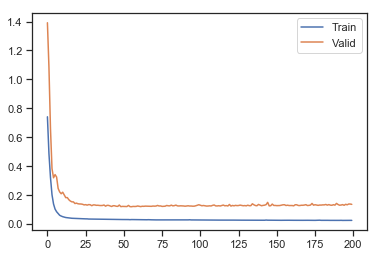

In [168]:
plt.plot(model_gru_fit.history['loss'],label='Train')
plt.plot(model_gru_fit.history['val_loss'],label='Valid')
plt.legend()
plt.show()

### 3.5

In [169]:
def modle_GRU_DP():
    model_gru_dp = Sequential()
    model_gru_dp.add(GRU(6, input_shape = (LB_win, feature_data.shape[1]), activation='linear', return_sequences=False, recurrent_dropout=0.5))
    model_gru_dp.add(Dense(7))
    model_gru_dp.compile(loss='mae', optimizer='adam',  metrics=['accuracy','mae'])
    return model_gru_dp
model_gru_dp=modle_GRU_DP()
model_gru_dp.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 6)                 252       
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 49        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [170]:
model_gru_dp_fit = model_gru_dp.fit(train_x, train_y, epochs=200, batch_size=66,
          validation_data=(val_x, val_y))

Train on 3076 samples, validate on 184 samples
Epoch 1/200
3076/3076 [==============================] - 4s 1ms/step - loss: 0.6850 - acc: 0.1112 - mean_absolute_error: 0.6850 - val_loss: 1.3380 - val_acc: 0.1359 - val_mean_absolute_error: 1.3380
Epoch 2/200
3076/3076 [==============================] - 1s 316us/step - loss: 0.4956 - acc: 0.1811 - mean_absolute_error: 0.4956 - val_loss: 1.0539 - val_acc: 0.1033 - val_mean_absolute_error: 1.0539
Epoch 3/200
3076/3076 [==============================] - 1s 290us/step - loss: 0.3505 - acc: 0.2204 - mean_absolute_error: 0.3505 - val_loss: 0.8257 - val_acc: 0.1196 - val_mean_absolute_error: 0.8257
Epoch 4/200
3076/3076 [==============================] - 1s 292us/step - loss: 0.2420 - acc: 0.1765 - mean_absolute_error: 0.2420 - val_loss: 0.6784 - val_acc: 0.1359 - val_mean_absolute_error: 0.6784
Epoch 5/200
3076/3076 [==============================] - 1s 290us/step - loss: 0.1856 - acc: 0.1310 - mean_absolute_error: 0.1856 - val_loss: 0.5912 - 

Epoch 82/200
3076/3076 [==============================] - 1s 283us/step - loss: 0.0326 - acc: 0.2263 - mean_absolute_error: 0.0326 - val_loss: 0.1073 - val_acc: 0.1902 - val_mean_absolute_error: 0.1073
Epoch 83/200
3076/3076 [==============================] - 1s 286us/step - loss: 0.0321 - acc: 0.2246 - mean_absolute_error: 0.0321 - val_loss: 0.0999 - val_acc: 0.2717 - val_mean_absolute_error: 0.0999
Epoch 84/200
3076/3076 [==============================] - 1s 297us/step - loss: 0.0320 - acc: 0.2211 - mean_absolute_error: 0.0320 - val_loss: 0.1011 - val_acc: 0.0978 - val_mean_absolute_error: 0.1011
Epoch 85/200
3076/3076 [==============================] - 1s 303us/step - loss: 0.0323 - acc: 0.2237 - mean_absolute_error: 0.0323 - val_loss: 0.1042 - val_acc: 0.0978 - val_mean_absolute_error: 0.1042
Epoch 86/200
3076/3076 [==============================] - 1s 286us/step - loss: 0.0322 - acc: 0.1967 - mean_absolute_error: 0.0322 - val_loss: 0.0987 - val_acc: 0.2500 - val_mean_absolute_erro

3076/3076 [==============================] - 1s 291us/step - loss: 0.0319 - acc: 0.2029 - mean_absolute_error: 0.0319 - val_loss: 0.0999 - val_acc: 0.1793 - val_mean_absolute_error: 0.0999
Epoch 163/200
3076/3076 [==============================] - 1s 301us/step - loss: 0.0317 - acc: 0.2308 - mean_absolute_error: 0.0317 - val_loss: 0.1029 - val_acc: 0.1359 - val_mean_absolute_error: 0.1029
Epoch 164/200
3076/3076 [==============================] - 1s 297us/step - loss: 0.0316 - acc: 0.2077 - mean_absolute_error: 0.0316 - val_loss: 0.1024 - val_acc: 0.2772 - val_mean_absolute_error: 0.1024
Epoch 165/200
3076/3076 [==============================] - 1s 288us/step - loss: 0.0318 - acc: 0.2188 - mean_absolute_error: 0.0318 - val_loss: 0.1009 - val_acc: 0.1304 - val_mean_absolute_error: 0.1009
Epoch 166/200
3076/3076 [==============================] - 1s 299us/step - loss: 0.0318 - acc: 0.2383 - mean_absolute_error: 0.0318 - val_loss: 0.1090 - val_acc: 0.1087 - val_mean_absolute_error: 0.1090

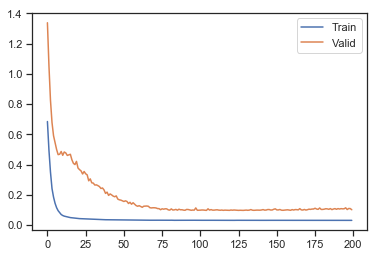

In [171]:
plt.plot(model_gru_dp_fit.history['loss'],label='Train')
plt.plot(model_gru_dp_fit.history['val_loss'],label='Valid')
plt.legend()
plt.show()

### 3.6

In [176]:
def modle_GRU_DP_2():
    model_gru_dp = Sequential()
    model_gru_dp.add(GRU(10, input_shape = (LB_win, feature_data.shape[1]), activation='relu', return_sequences=True, recurrent_dropout=0.5))
    model_gru_dp.add(GRU(10, input_shape = (1, 10), activation='linear', return_sequences=False, dropout = 0.1, recurrent_dropout=0.5))
    model_gru_dp.add(Dense(7))
    model_gru_dp.compile(loss='mae', optimizer='adam',  metrics=['accuracy','mae'])
    return model_gru_dp
model_gru_dp_2=modle_GRU_DP_2()
model_gru_dp_2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 28, 10)            540       
_________________________________________________________________
gru_8 (GRU)                  (None, 10)                630       
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 77        
Total params: 1,247
Trainable params: 1,247
Non-trainable params: 0
_________________________________________________________________


In [177]:
model_gru_dp_fit_2 = model_gru_dp_2.fit(train_x, train_y, epochs=200, batch_size=66,
          validation_data=(val_x, val_y))

Train on 3076 samples, validate on 184 samples
Epoch 1/200
3076/3076 [==============================] - 6s 2ms/step - loss: 0.4869 - acc: 0.1037 - mean_absolute_error: 0.4869 - val_loss: 1.0655 - val_acc: 0.1087 - val_mean_absolute_error: 1.0655
Epoch 2/200
3076/3076 [==============================] - 2s 602us/step - loss: 0.3032 - acc: 0.1232 - mean_absolute_error: 0.3032 - val_loss: 0.5375 - val_acc: 0.1087 - val_mean_absolute_error: 0.5375
Epoch 3/200
3076/3076 [==============================] - 2s 612us/step - loss: 0.2109 - acc: 0.1593 - mean_absolute_error: 0.2109 - val_loss: 0.3119 - val_acc: 0.1033 - val_mean_absolute_error: 0.3119
Epoch 4/200
3076/3076 [==============================] - 2s 629us/step - loss: 0.1622 - acc: 0.1502 - mean_absolute_error: 0.1622 - val_loss: 0.4397 - val_acc: 0.1033 - val_mean_absolute_error: 0.4397
Epoch 5/200
3076/3076 [==============================] - 2s 600us/step - loss: 0.1425 - acc: 0.1681 - mean_absolute_error: 0.1425 - val_loss: 0.6591 - 

Epoch 82/200
3076/3076 [==============================] - 2s 619us/step - loss: 0.0525 - acc: 0.1739 - mean_absolute_error: 0.0525 - val_loss: 0.1701 - val_acc: 0.1522 - val_mean_absolute_error: 0.1701
Epoch 83/200
3076/3076 [==============================] - 2s 633us/step - loss: 0.0529 - acc: 0.1697 - mean_absolute_error: 0.0529 - val_loss: 0.1971 - val_acc: 0.0978 - val_mean_absolute_error: 0.1971
Epoch 84/200
3076/3076 [==============================] - 2s 654us/step - loss: 0.0551 - acc: 0.1651 - mean_absolute_error: 0.0551 - val_loss: 0.2013 - val_acc: 0.1359 - val_mean_absolute_error: 0.2013
Epoch 85/200
3076/3076 [==============================] - 2s 621us/step - loss: 0.0534 - acc: 0.1697 - mean_absolute_error: 0.0534 - val_loss: 0.1683 - val_acc: 0.0978 - val_mean_absolute_error: 0.1683
Epoch 86/200
3076/3076 [==============================] - 2s 633us/step - loss: 0.0544 - acc: 0.1635 - mean_absolute_error: 0.0544 - val_loss: 0.1971 - val_acc: 0.0978 - val_mean_absolute_erro

3076/3076 [==============================] - 2s 558us/step - loss: 0.0504 - acc: 0.1499 - mean_absolute_error: 0.0504 - val_loss: 0.1755 - val_acc: 0.1522 - val_mean_absolute_error: 0.1755
Epoch 163/200
3076/3076 [==============================] - 2s 588us/step - loss: 0.0481 - acc: 0.1707 - mean_absolute_error: 0.0481 - val_loss: 0.1745 - val_acc: 0.1522 - val_mean_absolute_error: 0.1745
Epoch 164/200
3076/3076 [==============================] - 2s 592us/step - loss: 0.0523 - acc: 0.1850 - mean_absolute_error: 0.0523 - val_loss: 0.1782 - val_acc: 0.1522 - val_mean_absolute_error: 0.1782
Epoch 165/200
3076/3076 [==============================] - 2s 606us/step - loss: 0.0475 - acc: 0.1785 - mean_absolute_error: 0.0475 - val_loss: 0.1837 - val_acc: 0.1413 - val_mean_absolute_error: 0.1837
Epoch 166/200
3076/3076 [==============================] - 2s 585us/step - loss: 0.0487 - acc: 0.1925 - mean_absolute_error: 0.0487 - val_loss: 0.1798 - val_acc: 0.1522 - val_mean_absolute_error: 0.1798

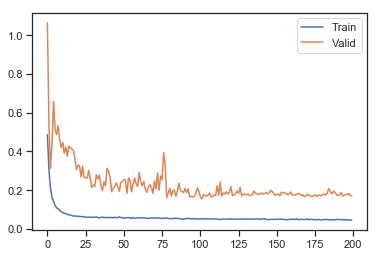

In [178]:
plt.plot(model_gru_dp_fit_2.history['loss'],label='Train')
plt.plot(model_gru_dp_fit_2.history['val_loss'],label='Valid')
plt.legend()
plt.show()

### 3.7

### 3.8

## Part 4

### 4.1

In [179]:
test_x = Test_LB
test_y = Test_Tgt

In [181]:
result_simple = model_simple.predict(test_x, batch_size=66)
result_lstm = model_lstm.predict(test_x, batch_size=66)
result_gru = model_gru.predict(test_x, batch_size=66)
result_gru_dp = model_gru_dp.predict(test_x, batch_size=66)
result_gru_dp_2 = model_gru_dp_2.predict(test_x, batch_size=66)

In [182]:
simple_result_mae=mean_absolute_error(Test_Tgt,result_simple)
lstm_result_mae=mean_absolute_error(Test_Tgt,result_lstm)
gru_result_mae=mean_absolute_error(Test_Tgt,result_gru)
gru_dp_result_mae=mean_absolute_error(Test_Tgt,result_gru_dp)
gru_dp_2_result_mae=mean_absolute_error(Test_Tgt,result_gru_dp_2)

In [215]:
print("The MAE of simple model is:",simple_result_mae)
print("The MAE of LSTM model is:", lstm_result_mae)
print("The MAE of GRU model is:",gru_result_mae)
print("The MAE of GRU dropout model is:",gru_dp_result_mae)
print("The MAE of 2 layer GRU dropout model is:",gru_dp_2_result_mae)

The MAE of simple model is: 0.24810300532227905
The MAE of LSTM model is: 0.22677614505481533
The MAE of GRU model is: 0.20363721807014717
The MAE of GRU dropout model is: 0.10223128662955239
The MAE of 2 layer GRU dropout model is: 0.2984385298036396


In [219]:
simple_result_rmse=np.sqrt(mean_squared_error(Test_Tgt,result_simple))
lstm_result_rmse=np.sqrt(mean_squared_error(Test_Tgt,result_lstm))
gru_result_rmse=np.sqrt(mean_squared_error(Test_Tgt,result_gru))
gru_dp_result_rmse=np.sqrt(mean_squared_error(Test_Tgt,result_gru_dp))
gru_dp_2_result_rmse=np.sqrt(mean_squared_error(Test_Tgt,result_gru_dp_2))

In [220]:
print("The RMSE of simple model is:",simple_result_rmse)
print("The RMSE of LSTM model is:", lstm_result_rmse)
print("The RMSE of GRU model is:",gru_result_rmse)
print("The RMSE of GRU dropout model is:",gru_dp_result_rmse)
print("The RMSE of 2 layer GRU dropout model is:",gru_dp_2_result_rmse)

The RMSE of simple model is: 0.3431447110099857
The RMSE of LSTM model is: 0.31918536852936535
The RMSE of GRU model is: 0.27459696931733346
The RMSE of GRU dropout model is: 0.17159983589390157
The RMSE of 2 layer GRU dropout model is: 0.3529372671687039


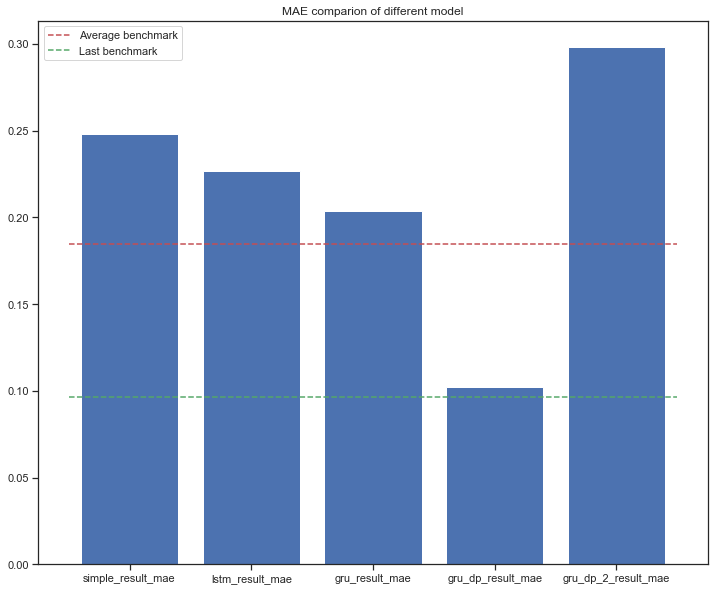

In [222]:
X = ['simple_result_mae','lstm_result_mae','gru_result_mae','gru_dp_result_mae','gru_dp_2_result_mae']
Y = [simple_result_mae,lstm_result_mae,gru_result_mae,gru_dp_result_mae,gru_dp_2_result_mae]
plt.figure(figsize=(12,10))
plt.bar(X,Y)
plt.hlines(Valid_Avg_Bmk, -0.5, 4.5, colors = "r", linestyles = "dashed",label='Average benchmark')
plt.hlines(Valid_Last_Bmk, -0.5, 4.5, colors = "g", linestyles = "dashed", label='Last benchmark')
plt.legend()
plt.title('MAE comparion of different model')
plt.show()

### 4.2

According to the above calculation and graph, we can conclued that the GRU with dropout model have the minmum MAE and RMSE. At the mean time, the GRU with dropout model is more closer to the benchmark of last day. So the GRU with dropout model performs the best.

## Part 5